<a href="https://colab.research.google.com/github/hilmanrozaini/STQ_trainee_CPO_time_series_forecast/blob/main/v3_Sabah_CPO_forecasting_2021_2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# using Sabah dataset, time period 2021 to 2023, sourced from MPOB

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
import seaborn as sns
import matplotlib.dates as mdates

# EDA

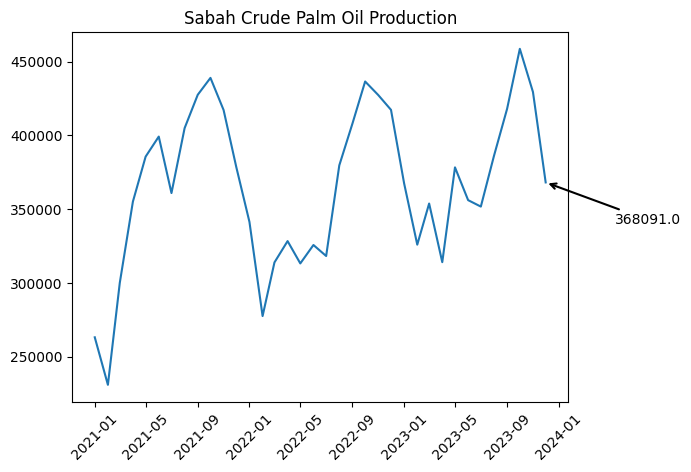

In [2]:
#original plot
#import matplotlib.dates as mdates

#read data
dat1_1 = pd.read_csv('/content/drive/MyDrive/Sabah CPO project (Steven)/SABAH_2021_2023.csv')

# change data type
dat1_1['Month'] = pd.to_datetime(dat1_1['Month'], format='%d/%m/%Y')   # convert into data format
dat1_1['Production'] = dat1_1['Production'].apply(lambda x: int(x.replace(',', '')))  # remove comma from figures and convert into integer data type

# Prepare the data
# dat1_1 = dat1_1[['Month', 'Production']].copy()
# dat1_1.columns = ['ds', 'y']

plt.plot(dat1_1['Month'], dat1_1['Production'])

# Plot the forecast
#fig = model.plot(forecast, xlabel='Year', ylabel='CPO (tonnes)')

# Set the x-axis ticks to show every year
#gca().xaxis.set_major_locator(mdates.YearLocator())

plt.title('Sabah Crude Palm Oil Production')


# Annotate the last point
last_point_index = dat1_1['Month'].idxmax()  # Assuming 'Month' is in datetime format
last_point_value = dat1_1['Production'].iloc[-1]

plt.annotate(f"{last_point_value:.1f}", xy=(dat1_1['Month'].iloc[-1], last_point_value), xycoords='data',
             xytext=(50, -30), textcoords='offset points',
             arrowprops=dict(arrowstyle="->", linewidth=1.5))

#ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
#ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
plt.xticks(rotation=45)

# Show the plot
plt.show()

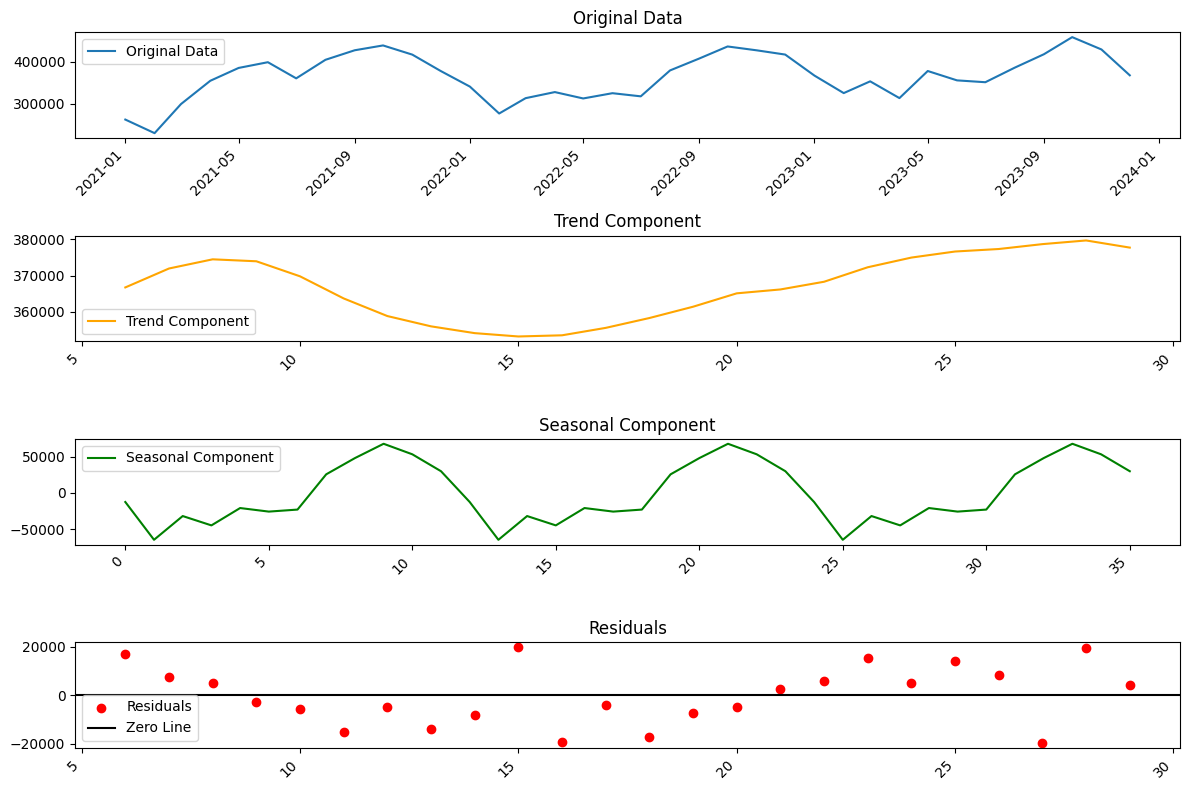

In [3]:
## composition analysis

from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

#prepare the data
dat1_1 = dat1_1[['Month', 'Production']].copy()
dat1_1.columns = ['ds', 'y']

# Assuming dat1['ds'] contains your date or time index
result = seasonal_decompose(dat1_1['y'], model='additive', period=12)

# Plotting with custom x-axis labels
plt.figure(figsize=(12, 8))

# Original Data
plt.subplot(411)
plt.plot(dat1_1['ds'], dat1_1['y'], label='Original Data')
plt.legend()
plt.title('Original Data')

# fig.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=6))


# Trend Component
plt.subplot(412)
plt.plot(result.trend, label='Trend Component', color='orange')
plt.legend()
plt.title('Trend Component')

# Seasonal Component
plt.subplot(413)
plt.plot(result.seasonal, label='Seasonal Component', color='green')
plt.legend()
plt.title('Seasonal Component')

# Residuals
plt.subplot(414)
plt.scatter(result.resid.index,result.resid, label='Residuals', color='red')
plt.axhline(y=0, color='black', linestyle='-', label='Zero Line')
plt.legend()
plt.title('Residuals')

# Add x-axis labels to all subplots
for ax in plt.gcf().axes:
    plt.sca(ax)
    plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()


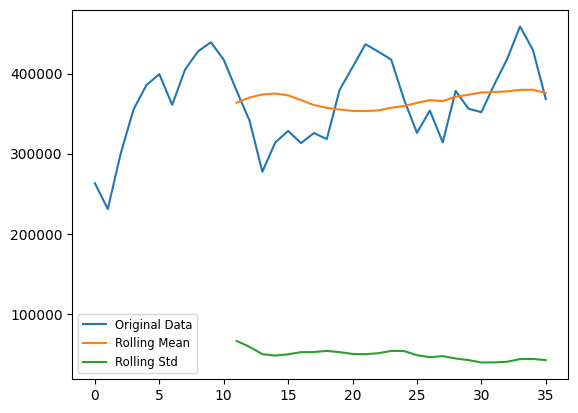

Results of Dicky-Fuller Test:
ADF Statistic: -4.176753
p-value: 0.000721
critical values:
1% -3.6699197407407405
5% -2.9640707407407407
10% -2.621171111111111


In [4]:
# stationarity of the time series data
# we need to test for stationarity first (using dicky-fuller test) before proceed to ACF & PACF

# https://www.kaggle.com/code/sumi25/understand-arima-and-tune-p-d-q

# stationar test: if dicky-fuller test < 0.05, then we assume it is stationary
# https://analyticsindiamag.com/quick-way-to-find-p-d-and-q-values-for-arima/

# rolling mean = used to assess the model's stability over time

from statsmodels.tsa.stattools import adfuller

rolling_mean = dat1_1['y'].rolling(window=12).mean()  # Adjust 'window' based on the length of your cycle
rolling_std = dat1_1['y'].rolling(window=12).std()

plt.plot(figsize=(30,20))
plt.plot(dat1_1['y'], label='Original Data')
plt.plot(rolling_mean, label='Rolling Mean')
plt.plot(rolling_std, label='Rolling Std')
plt.legend(loc='lower left', fontsize='small')
plt.show()

# performing dicky-fuller test
print('Results of Dicky-Fuller Test:')
result = adfuller(dat1_1['y'], autolag = 'AIC')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('critical values:')

for key, value in result[4].items():
  print(key,value)

# testing stationarity of store type a
# test_stationarity(sales_a)

# using autocorrelation

# from statsmodels.graphics.tsaplots import plot_acf
# fig, (ax1, ax2, ax3) = plt.subplots(3)
# plot_acf(data.Passengers, ax=ax1)
# plot_acf(data.Passengers.diff().dropna(), ax=ax2)
# plot_acf(data.Passengers.diff().diff().dropna(), ax=ax3)

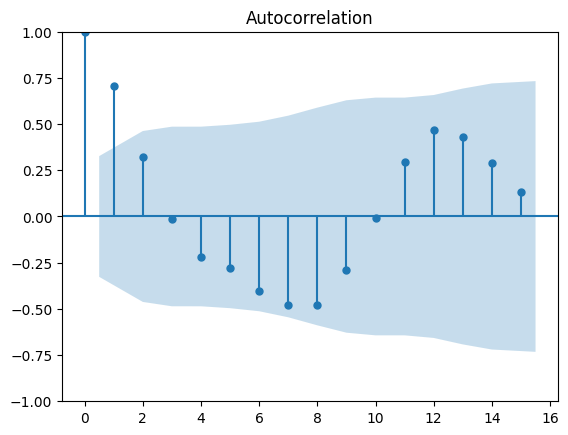

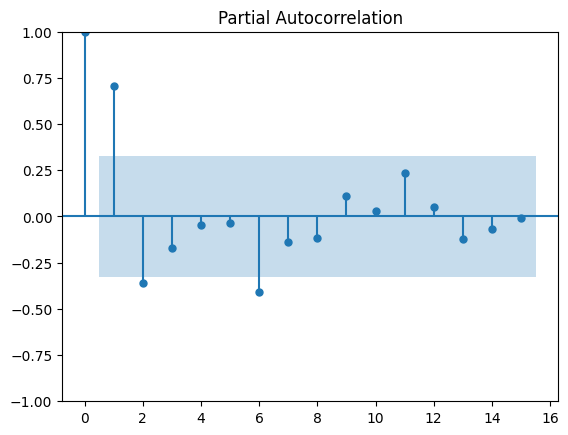

In [5]:
# autocorrelation (AR)

# Autocorrelation
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

#prepare the data
# dat1_1 = dat1_1[['Month', 'Production']].copy()
dat1_1.columns = ['ds', 'y']

#ACF
plot_acf(dat1_1['y'], lags=15);

#PACF
plot_pacf(dat1_1['y'], lags=15);  # because PACF currently has nlags of 30, so need to put lags < 50% of 30

In [6]:
# #cycle

# detrended = dat1_1['y'] - result.seasonal - result.trend
# plt.plot(detrended, label='Detrended Data')
# plt.legend()
# plt.show()


# FB Prophet Library Forecasting

## Scale = 1

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3mje7wdp/mg4rgz5m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3mje7wdp/_vnhdccl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84322', 'data', 'file=/tmp/tmp3mje7wdp/mg4rgz5m.json', 'init=/tmp/tmp3mje7wdp/_vnhdccl.json', 'output', 'file=/tmp/tmp3mje7wdp/prophet_modelrt921gcy/prophet_model-20240301130422.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:04:22 - cmdstanpy - INFO - Chain [1] start processing
I

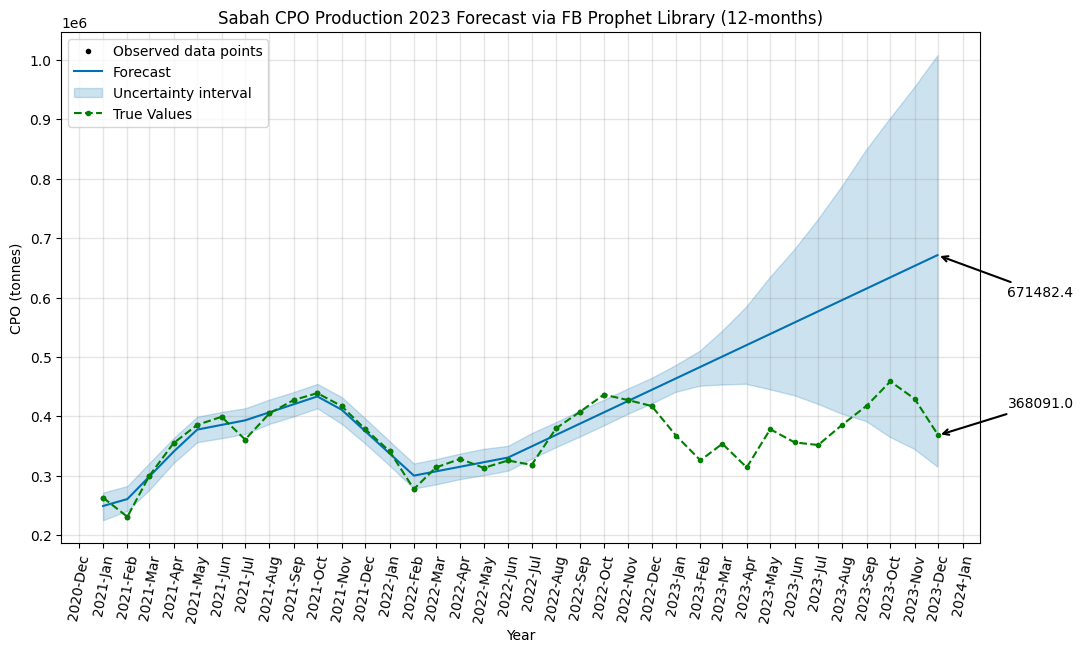

Mean Absolute Error (MAE): 72699.15
Mean Absolute Percentage Error (MAPE): 19.7722%
Change Point Scale is: 1
forecasted value is:  671482.38
actual value is:  368091.00


In [7]:
## FB prophet without cross validation (scale = 1)

from prophet import Prophet
import matplotlib.pyplot as plt
import pandas as pd

# load data
dat1 = pd.read_csv('/content/drive/MyDrive/Sabah CPO project (Steven)/SABAH_2021_2023.csv')

# change data type
dat1['Month'] = pd.to_datetime(dat1['Month'], format='%d/%m/%Y')   # convert into data format
dat1['Production'] = dat1['Production'].apply(lambda x: int(x.replace(',', '')))  # remove comma from figures and convert into integer data type

# Prepare the data
dat1 = dat1[['Month', 'Production']].copy()
dat1.columns = ['ds', 'y']


# Ensure 'ds' is of datetime data type and 'y' is numeric
dat1['ds'] = pd.to_datetime(dat1['ds'])
dat1['y'] = pd.to_numeric(dat1['y'])

# # Assuming your dataframe is named df and has 'ds' and 'y' columns
# df['ds'] = pd.to_datetime(df['ds'])
# df['y'] = pd.to_numeric(df['y'])

# Split the data into training and test sets
train = dat1[:-12]  # Use all data except the last 12 months for training
test = dat1[-12:]   # Use the last 12 months for testing

# changepoint_scale
changepoint_prior_scale =1

# Create a Prophet model
model = Prophet(changepoint_prior_scale=changepoint_prior_scale)

# Fit the model to the training data
model.fit(train)

# Create future dates for forecasting
future = model.make_future_dataframe(periods=12, freq='M')

# Perform the forecasting
forecast = model.predict(future)

# Plot the forecast
fig = model.plot(forecast, xlabel='Year', ylabel='CPO (tonnes)')

# Plot the true values for the test set
# plt.plot(test['ds'], test['y'], label='True Values', color='green', marker='.')

# Plot the true values for the test set
plt.plot(dat1['ds'], dat1['y'], label='True Values', color='green', marker='.', linestyle= '--')

# Get the last point of the forecast
last_point = forecast.tail(1)

# Annotate the value on the last point
plt.annotate(f"{last_point['yhat'].values[0]:.1f}", xy=(last_point['ds'].values[0], last_point['yhat'].values[0]), xycoords='data',
             xytext=(50, -30), textcoords='offset points',
             arrowprops=dict(arrowstyle="->", linewidth=1.5))

# Annotate the true value on the last point
last_true_point = test.tail(1)
plt.annotate(f"{last_true_point['y'].values[0]:.1f}", xy=(last_true_point['ds'].values[0], last_true_point['y'].values[0]), xycoords='data',
             xytext=(50, 20), textcoords='offset points',
             arrowprops=dict(arrowstyle="->", linewidth=1.5))

# Set the x-axis ticks to show every year / months
#fig.gca().xaxis.set_major_locator(mdates.YearLocator())
fig.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))

#ax = fig.plot(figsize=(15,5))
fig.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
plt.xticks(rotation=80)


# Adjust the plot
plt.title('Sabah CPO Production 2023 Forecast via FB Prophet Library (12-months)')
plt.legend(loc='upper left')
plt.show()

# -------------performance metrics ---------------------

from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error

# Extract relevant columns
y_true = dat1['y']
y_pred = forecast['yhat']

# Align the time periods
common_dates = y_true.index.intersection(y_pred.index)
y_true_aligned = y_true.loc[common_dates]
y_pred_aligned = y_pred.loc[common_dates]

# Calculate MAPE
mape = mean_absolute_percentage_error(y_true_aligned, y_pred_aligned)
mae = mean_absolute_error(y_true_aligned, y_pred_aligned)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape * 100 :.4f}%")
print(f"Change Point Scale is: {changepoint_prior_scale}")
print(f"forecasted value is: {last_point['yhat'].values[0] : .2f}")
print(f"actual value is: {last_true_point['y'].values[0]: .2f}")

## Scale = 5

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3mje7wdp/oox_g0z2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3mje7wdp/a06w5ym1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25099', 'data', 'file=/tmp/tmp3mje7wdp/oox_g0z2.json', 'init=/tmp/tmp3mje7wdp/a06w5ym1.json', 'output', 'file=/tmp/tmp3mje7wdp/prophet_modelgq9pejzt/prophet_model-20240301130424.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:04:24 - cmdstanpy - INFO - Chain [1] start processing
I

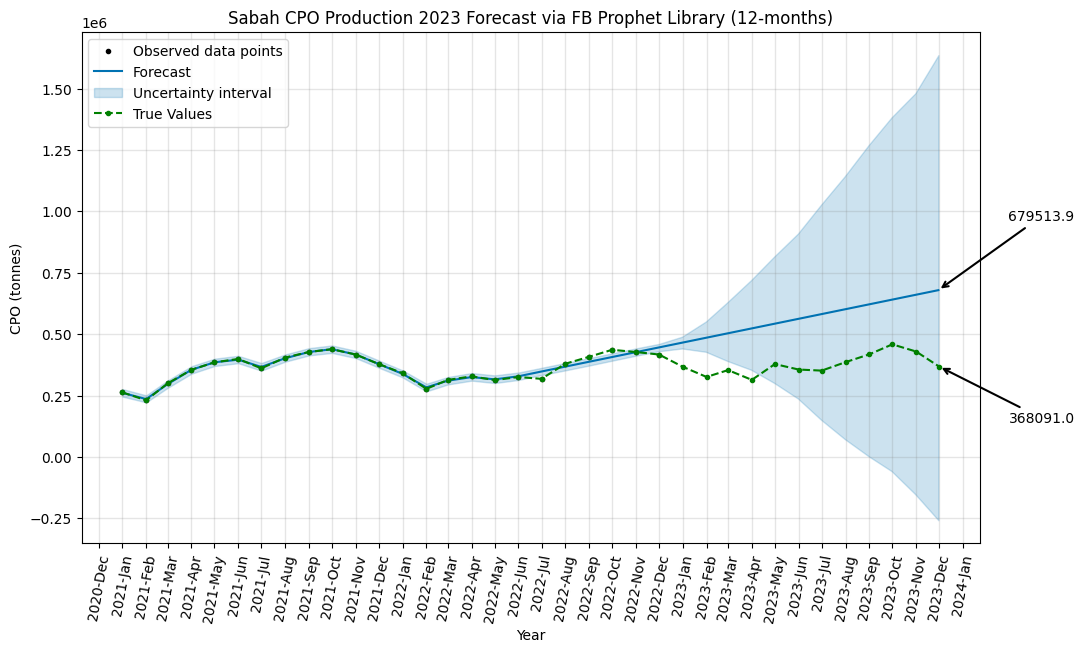

Mean Absolute Error (MAE): 70022.92
Mean Absolute Percentage Error (MAPE): 18.8362%
Change Point Scale is: 5
forecasted value is:  679513.86
actual value is:  368091.00


In [8]:
## Fb prophet without cross validation (scale = 5)

from prophet import Prophet
import matplotlib.pyplot as plt
import pandas as pd

# load data
dat1_1 = pd.read_csv('/content/drive/MyDrive/Sabah CPO project (Steven)/SABAH_2021_2023.csv')

# change data type
dat1_1['Month'] = pd.to_datetime(dat1_1['Month'], format='%d/%m/%Y')   # convert into data format
dat1_1['Production'] = dat1_1['Production'].apply(lambda x: int(x.replace(',', '')))  # remove comma from figures and convert into integer data type

# Prepare the data
dat1_1 = dat1_1[['Month', 'Production']].copy()
dat1_1.columns = ['ds', 'y']

# Ensure 'ds' is of datetime data type and 'y' is numeric
dat1_1['ds'] = pd.to_datetime(dat1_1['ds'])
dat1_1['y'] = pd.to_numeric(dat1_1['y'])

# Split the data into training and test sets
train = dat1_1[:-12]  # Use all data except the last 12 months for training
test = dat1_1[-12:]   # Use the last 12 months for testing

#changepoint scale
changepoint_prior_scale = 5

# Create a Prophet model
model = Prophet(changepoint_prior_scale= changepoint_prior_scale)

# Fit the model to the training data
model.fit(train)

# Create future dates for forecasting
future = model.make_future_dataframe(periods=12, freq='M')

# Perform the forecasting
forecast = model.predict(future)

# Plot the forecast
fig = model.plot(forecast, xlabel='Year', ylabel='CPO (tonnes)')

# # Plot the true values for the test set
# plt.plot(test['ds'], test['y'], label='True Values', color='green', marker='.')
plt.plot(dat1['ds'], dat1['y'], label='True Values', color='green', marker='.', linestyle = '--')

# Get the last point of the forecast
last_point = forecast.tail(1)

# Annotate the value on the last point
plt.annotate(f"{last_point['yhat'].values[0]:.1f}", xy=(last_point['ds'].values[0], last_point['yhat'].values[0]), xycoords='data',
             xytext=(50, 50), textcoords='offset points',
             arrowprops=dict(arrowstyle="->", linewidth=1.5))

# Annotate the true value on the last point
last_true_point = test.tail(1)
plt.annotate(f"{last_true_point['y'].values[0]:.1f}", xy=(last_true_point['ds'].values[0], last_true_point['y'].values[0]), xycoords='data',
             xytext=(50, -40), textcoords='offset points',
             arrowprops=dict(arrowstyle="->", linewidth=1.5))

# Set the x-axis ticks to show every year / months
#fig.gca().xaxis.set_major_locator(mdates.YearLocator())
fig.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))

#ax = fig.plot(figsize=(15,5))
fig.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
plt.xticks(rotation=80)

# Adjust the plot
plt.title('Sabah CPO Production 2023 Forecast via FB Prophet Library (12-months)')
plt.legend(loc='upper left')
plt.show()

# -------------performance metrics ---------------------

from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error

# Extract relevant columns
y_true = dat1_1['y']
y_pred = forecast['yhat']

# Align the time periods
common_dates = y_true.index.intersection(y_pred.index)
y_true_aligned = y_true.loc[common_dates]
y_pred_aligned = y_pred.loc[common_dates]

# Calculate MAPE
mape = mean_absolute_percentage_error(y_true_aligned, y_pred_aligned)
mae = mean_absolute_error(y_true_aligned, y_pred_aligned)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape * 100 :.4f}%")
print(f"Change Point Scale is: {changepoint_prior_scale}")
print(f"forecasted value is: {last_point['yhat'].values[0] : .2f}")
print(f"actual value is: {last_true_point['y'].values[0]: .2f}")

# SARIMA

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


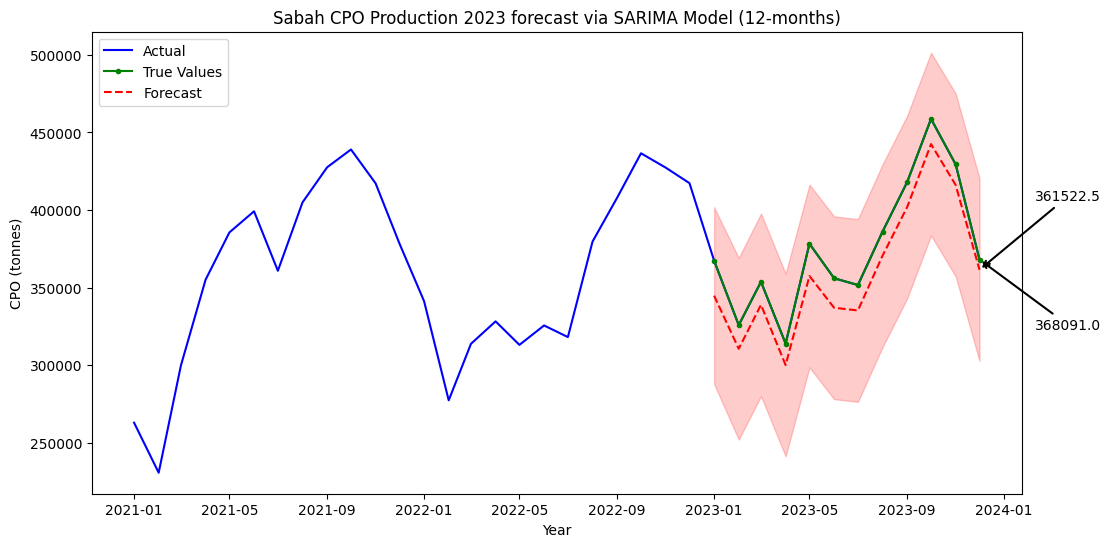

order: (1,0,1)
seasonal order: (1,1,1,12)
MAPE:  4.2650%
MAE:  15858.25
forecasted value is:  361522.53
actual value is:  368091.00


In [9]:
#applying cross validation into the model
# but i gonna ignore X-valid since the p,d,q = (0,0,0) , seasonal order = (0,1,1,12) does not really account seasonality
# so i gonna go with default at p,d,q, = (1,0,1), seasonal order = (0,1,1,12)

import itertools
import numpy as np
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates

# Load and preprocess the data
dat2_1 = pd.read_csv('/content/drive/MyDrive/Sabah CPO project (Steven)/SABAH_2021_2023.csv')
dat2_1['Month'] = pd.to_datetime(dat2_1['Month'], format='%d/%m/%Y')
dat2_1['Production'] = dat2_1['Production'].apply(lambda x: int(x.replace(',', '')))
dat2_1 = dat2_1[['Month', 'Production']].copy()
dat2_1.columns = ['ds', 'y']
dat2_1['ds'] = pd.to_datetime(dat2_1['ds'])
dat2_1['y'] = pd.to_numeric(dat2_1['y'])

# Split the data into training and test sets
train = dat2_1[:-12]
test = dat2_1[-12:]

# # Define the parameter grid for SARIMA
# p = d = q = range(0, 2)
# pdq = list(itertools.product(p, d, q))
# seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

# # Perform grid search with cross-validation
# best_mape = float('inf')
# best_order = None
# best_seasonal_order = None

# for order in pdq:
#     for seasonal_order in seasonal_pdq:
#         try:
#             # Fit the SARIMA model to the training data
#             model = SARIMAX(train['y'], order=order, seasonal_order=seasonal_order)
#             results = model.fit()

#             # Perform the forecasting
#             forecast = results.get_forecast(steps=12).predicted_mean

#             # Calculate MAPE on the test set
#             mape = mean_absolute_percentage_error(test['y'], forecast)

#             # calculate MAE on test set
#             mae = mean_absolute_error(test['y'], forecast)

#             # Update the best parameters if the current model has a lower MAPE
#             if mape < best_mape:
#                 best_mape = mape
#                 best_mae = mae
#                 best_order = order
#                 best_seasonal_order = seasonal_order

#         except Exception as e:
#             print(f"Error for order={order}, seasonal_order={seasonal_order}: {e}")

# Now you can use the best hyperparameters to fit the final model and make predictions
final_model = SARIMAX(dat2_1['y'], order=(1,0,1), seasonal_order=(1,1,1,12))
final_results = final_model.fit()



# Plot the final forecast
forecast = final_results.get_forecast(steps=12)
# forecast = final_results.get_forecast(steps=len(dat2_1))
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

#             # Calculate MAPE on the test set
mape = mean_absolute_percentage_error(test['y'], forecast_mean)

#             # calculate MAE on test set
mae = mean_absolute_error(test['y'], forecast_mean)

plt.figure(figsize=(12, 6))


# # Calculate the average of the confidence interval for the entire time period
# forecast_average = forecast_ci.mean(axis=1)
# # Plot the forecasted values for the entire time period using the average of the confidence interval
# plt.plot(dat2_1['ds'], forecast_average, label='Forecast (Average CI)', color='orange', linestyle='dashed')

# # Calculate 25th percentile (Q1) of forecasted confidence interval
# forecast_threshold_25 = np.percentile(forecast_ci['lower y'], 25)
# plt.axhline(y=forecast_threshold_25, color='black', linestyle='--', label='Forecast Baseline (25%)')

# # Calculate the average of the forecasted confidence interval for the entire time period
# forecast_average = forecast_ci.mean(axis=1)
# # Plot the forecasted values for the entire time period using the average of the confidence interval
# plt.plot(dat2_1['ds'], forecast_average, label='Forecast (Average CI)', color='orange', linestyle='dashed')

#original plot
plt.plot(dat2_1['ds'], dat2_1['y'], label='Actual', color='blue')

#true value on final year
plt.plot(test['ds'], test['y'], label='True Values', color='green', marker='.')

#forecasted value
# plt.plot(test['ds'], forecast_mean, label='Forecast', color='red', linestyle='dashed')
plt.plot(test['ds'], forecast_mean, label='Forecast', color='red', linestyle='dashed')

#confidence interval
plt.fill_between(test['ds'], forecast_ci['lower y'], forecast_ci['upper y'], color='red', alpha=0.2)

# Annotate the forecasted value at the last point
plt.annotate(f"{forecast_mean.iloc[-1]:.1f}", xy=(test['ds'].iloc[-1], forecast_mean.iloc[-1]),
             xycoords='data', xytext=(40, 50), textcoords='offset points', arrowprops=dict(arrowstyle="->", linewidth=1.5))

# Annotate the last point of the actual values
plt.annotate(f"{test['y'].iloc[-1]:.1f}", xy=(test['ds'].iloc[-1], test['y'].iloc[-1]),
             xycoords='data', xytext=(40, -50), textcoords='offset points', arrowprops=dict(arrowstyle="->", linewidth=1.5))

# # Calculate 25th percentile (Q1) of historical production
baseline_threshold = np.percentile(dat2_1['y'], 25)
# plt.axhline(y=baseline_threshold, color='magenta', linestyle='--', label='historical Baseline (25%)')

# # Calculate 25th percentile (Q1) of forecasted production
forecast_baseline_threshold = np.percentile(forecast_ci['lower y'], 25)
# plt.axhline(y=forecast_baseline_threshold, color='orange', linestyle='--', label='Forecast Baseline (25%)')

# Calculate the average between historical baseline and forecasted baseline
average_baseline = (baseline_threshold + forecast_baseline_threshold) / 2
# plt.axhline(y=average_baseline, color='black', linestyle='--', label='Minimum Baseline')


# plot graph
plt.title('Sabah CPO Production 2023 forecast via SARIMA Model (12-months)')
plt.xlabel('Year')
plt.ylabel('CPO (tonnes)')
plt.legend(loc="upper left")
plt.show()


# Print the best hyperparameters
print(f"order: (1,0,1)")
print(f"seasonal order: (1,1,1,12)")
print(f"MAPE: {mape*100 : .4f}%")
print(f"MAE: {mae: .2f}")
print(f"forecasted value is: {forecast_mean.iloc[-1] : .2f}")
print(f"actual value is: {test['y'].iloc[-1] : .2f}")
# print(f"minumum historical baseline is: {baseline_threshold : 2f}")
# print(f"minumum forecasted baseline is: {forecast_baseline_threshold : 2f}")
# print(f"minumum baseline is: {average_baseline : 2f}")


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


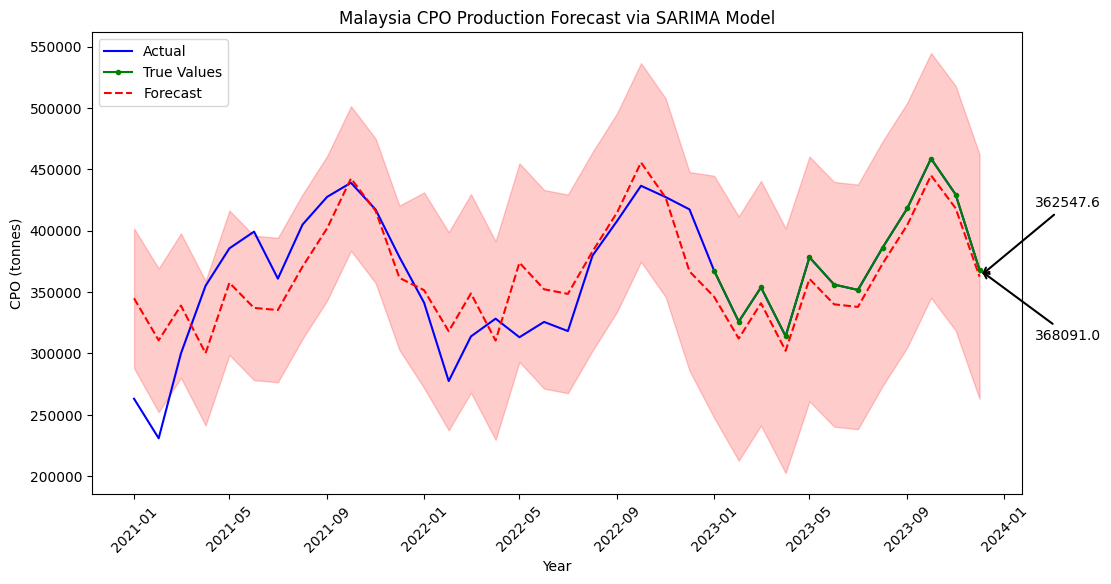

order: (1,0,1)
seasonal order: (1,1,1,12)
MAPE:  4.2650%
MAE:  15858.25
forecasted value is:  362547.64
actual value is:  368091.00
minumum baseline is:  325815.250000


In [10]:
import itertools
import numpy as np
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates

# Load and preprocess the data
dat2_1 = pd.read_csv('/content/drive/MyDrive/Sabah CPO project (Steven)/SABAH_2021_2023.csv')
dat2_1['Month'] = pd.to_datetime(dat2_1['Month'], format='%d/%m/%Y')
dat2_1['Production'] = dat2_1['Production'].apply(lambda x: int(x.replace(',', '')))
dat2_1 = dat2_1[['Month', 'Production']].copy()
dat2_1.columns = ['ds', 'y']
dat2_1['ds'] = pd.to_datetime(dat2_1['ds'])
dat2_1['y'] = pd.to_numeric(dat2_1['y'])

# Split the data into training and test sets
train = dat2_1[:-12]
test = dat2_1[-12:]

# # Define the parameter grid for SARIMA
# p = d = q = range(0, 2)
# pdq = list(itertools.product(p, d, q))
# seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

# # Perform grid search with cross-validation
# best_mape = float('inf')
# best_order = None
# best_seasonal_order = None

# for order in pdq:
#     for seasonal_order in seasonal_pdq:
#         try:
#             # Fit the SARIMA model to the training data
#             model = SARIMAX(train['y'], order=order, seasonal_order=seasonal_order)
#             results = model.fit()

#             # Perform the forecasting
#             forecast = results.get_forecast(steps=12).predicted_mean

#             # Calculate MAPE on the test set
#             mape = mean_absolute_percentage_error(test['y'], forecast)

#             # calculate MAE on test set
#             mae = mean_absolute_error(test['y'], forecast)

#             # Update the best parameters if the current model has a lower MAPE
#             if mape < best_mape:
#                 best_mape = mape
#                 best_mae = mae
#                 best_order = order
#                 best_seasonal_order = seasonal_order

#         except Exception as e:
#             print(f"Error for order={order}, seasonal_order={seasonal_order}: {e}")

# Now you can use the best hyperparameters to fit the final model and make predictions
final_model = SARIMAX(dat2_1['y'], order=(1,0,1), seasonal_order=(1,1,1,12))
final_results = final_model.fit()



# Plot the final forecast for the entire time period
forecast_full = final_results.get_forecast(steps=len(dat2_1))
forecast_mean_full = forecast_full.predicted_mean
forecast_ci_full = forecast_full.conf_int()

# Plot the actual values
plt.figure(figsize=(12, 6))
plt.plot(dat2_1['ds'], dat2_1['y'], label='Actual', color='blue')

# Plot the true values for the test set
plt.plot(test['ds'], test['y'], label='True Values', color='green', marker='.')

# Plot the forecasted values for the entire time period
plt.plot(dat2_1['ds'], forecast_mean_full, label='Forecast', color='red', linestyle='dashed')

# Plot the confidence interval for the entire time period
plt.fill_between(dat2_1['ds'], forecast_ci_full['lower y'], forecast_ci_full['upper y'], color='red', alpha=0.2)

# Annotate the forecasted value at the last point
plt.annotate(f"{forecast_mean_full.iloc[-1]:.1f}", xy=(test['ds'].iloc[-1], forecast_mean_full.iloc[-1]),
             xycoords='data', xytext=(40, 50), textcoords='offset points', arrowprops=dict(arrowstyle="->", linewidth=1.5))

# Annotate the last point of the actual values
plt.annotate(f"{test['y'].iloc[-1]:.1f}", xy=(test['ds'].iloc[-1], test['y'].iloc[-1]),
             xycoords='data', xytext=(40, -50), textcoords='offset points', arrowprops=dict(arrowstyle="->", linewidth=1.5))

# # Calculate 25th percentile (Q1) of historical production
# baseline_threshold = np.percentile(dat2_1['y'], 25)
# plt.axhline(y=baseline_threshold, color='green', linestyle='--', label='historical Baseline (25%)')

# # Calculate 25th percentile (Q1) of forecasted production
# forecast_baseline_threshold = np.percentile(forecast_ci_full['lower y'], 25)
# plt.axhline(y=forecast_baseline_threshold, color='black', linestyle='--', label='Forecast Baseline (25%)')

# Set the x-axis ticks to show every year / months
#fig.gca().xaxis.set_major_locator(mdates.YearLocator())
fig.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))

#ax = fig.plot(figsize=(15,5))
fig.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)

# label plot
plt.title('Malaysia CPO Production Forecast via SARIMA Model')
plt.xlabel('Year')
plt.ylabel('CPO (tonnes)')
plt.legend(loc="upper left")
plt.show()

# --------- performance metrics -------------
# Print the best hyperparameters
print(f"order: (1,0,1)")
print(f"seasonal order: (1,1,1,12)")
print(f"MAPE: {mape*100 : .4f}%")
print(f"MAE: {mae: .2f}")
print(f"forecasted value is: {forecast_mean_full.iloc[-1] : .2f}")
print(f"actual value is: {test['y'].iloc[-1] : .2f}")
print(f"minumum baseline is: {baseline_threshold : 2f}")



# Exponential Smoothing

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


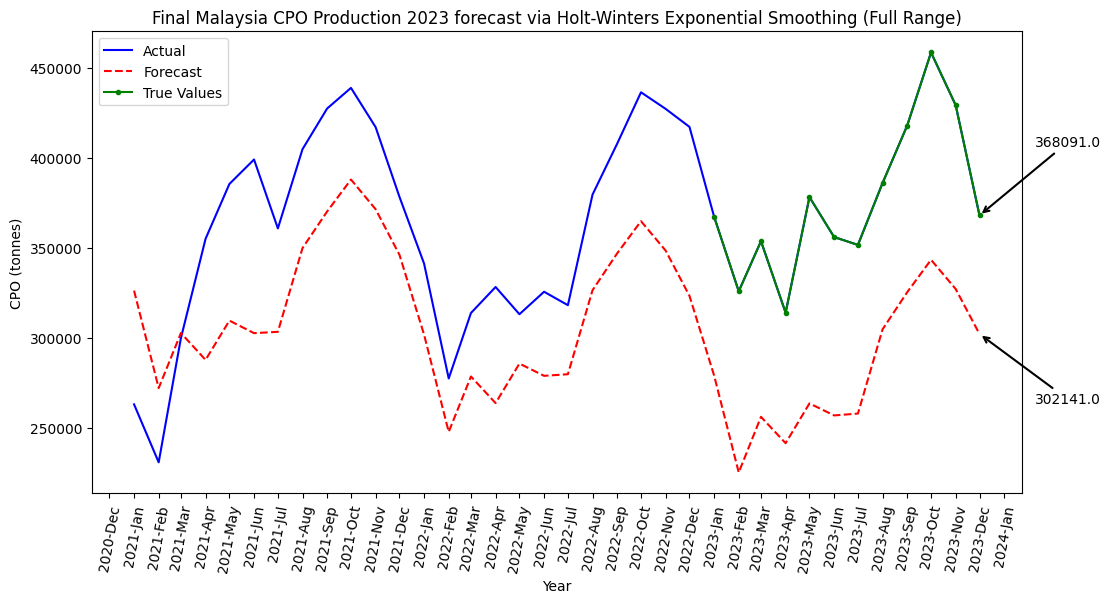

Trend and Seasonal Combination: multiplicative, add
MAPE:  18.1953%
MAE:  66960.29
Forecasted Value:  302141.00
Actual Value:  368091.00


In [11]:
import itertools
import numpy as np
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates

# Load and preprocess the data
dat4 = pd.read_csv('/content/drive/MyDrive/Sabah CPO project (Steven)/SABAH_2021_2023.csv')
dat4['Month'] = pd.to_datetime(dat4['Month'], format='%d/%m/%Y')
dat4['Production'] = dat4['Production'].apply(lambda x: int(x.replace(',', '')))
dat4 = dat4[['Month', 'Production']].copy()
dat4.columns = ['ds', 'y']
dat4['ds'] = pd.to_datetime(dat4['ds'])
dat4['y'] = pd.to_numeric(dat4['y'])

# Define the parameter grid for Holt-Winters
trend = "multiplicative"
seasonal = "add"

# Split the data into training and test sets
train = dat4[:-12]
test = dat4[-12:]

# Now you can use the best hyperparameters to fit the final model and make predictions
final_model = ExponentialSmoothing(dat4['y'], trend=trend, seasonal=seasonal, seasonal_periods=12).fit()

# Perform forecasting for the entire time period
forecast_full = final_model.forecast(steps=len(dat4))

# Calculate MAPE on the entire time period
mape = mean_absolute_percentage_error(dat4['y'], forecast_full)

# Calculate MAE on the entire time period
mae = mean_absolute_error(dat4['y'], forecast_full)

plt.figure(figsize=(12, 6))
plt.plot(dat4['ds'], dat4['y'], label='Actual', color='blue')
plt.plot(dat4['ds'], forecast_full, label='Forecast', color='red', linestyle='dashed')

# Plot the true values for the test set
plt.plot(test['ds'], test['y'], label='True Values', color='green', marker='.')

# Annotate the forecasted value at the last point
plt.annotate(f"{forecast_full.iloc[-1]:.1f}", xy=(dat4['ds'].iloc[-1], forecast_full.iloc[-1]),
             xycoords='data', xytext=(40, -50), textcoords='offset points', arrowprops=dict(arrowstyle="->", linewidth=1.5))

# Annotate the last point of the actual values
plt.annotate(f"{test['y'].iloc[-1]:.1f}", xy=(test['ds'].iloc[-1], test['y'].iloc[-1]),
             xycoords='data', xytext=(40, 50), textcoords='offset points', arrowprops=dict(arrowstyle="->", linewidth=1.5))

# Set the x-axis ticks to show every month
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
plt.xticks(rotation=80)

plt.title('Final Malaysia CPO Production 2023 forecast via Holt-Winters Exponential Smoothing (Full Range)')
plt.xlabel('Year')
plt.ylabel('CPO (tonnes)')
plt.legend(loc="upper left")
plt.show()

# Print performance metrics
print(f"Trend and Seasonal Combination: {trend}, {seasonal}")
print(f"MAPE: {mape*100 : .4f}%")
print(f"MAE: {mae: .2f}")
print(f"Forecasted Value: {forecast_full.iloc[-1] : .2f}")
print(f"Actual Value: {dat4['y'].iloc[-1] : .2f}")


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


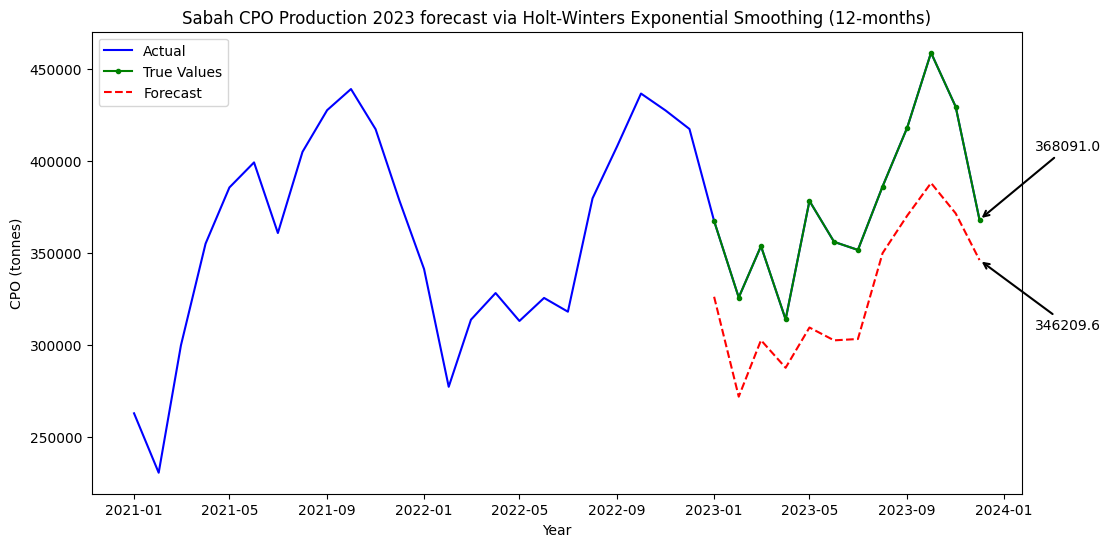

trend and seasonal combination: multiplicative , add
MAPE:  12.7527%
MAE:  48090.04
forecasted value is:  346209.61
actual value is:  368091.00


In [12]:
## applying the model suggested from Cross Validation

import itertools
import numpy as np
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates

# Load and preprocess the data
dat4 = pd.read_csv('/content/drive/MyDrive/Sabah CPO project (Steven)/SABAH_2021_2023.csv')
dat4['Month'] = pd.to_datetime(dat4['Month'], format='%d/%m/%Y')
dat4['Production'] = dat4['Production'].apply(lambda x: int(x.replace(',', '')))
dat4 = dat4[['Month', 'Production']].copy()
dat4.columns = ['ds', 'y']
dat4['ds'] = pd.to_datetime(dat4['ds'])
dat4['y'] = pd.to_numeric(dat4['y'])

# Split the data into training and test sets
train = dat4[:-12]
test = dat4[-12:]

# # Define the parameter grid for Holt-Winters
trend = "multiplicative" #["add", "additive", "additive_t", "multiplicative", "multiplicative_t"]
seasonal = "add" #["add", "additive", "multiplicative", "multiplicative_t"]
# combinations = list(itertools.product(trend, seasonal))


# Now you can use the best hyperparameters to fit the final model and make predictions
final_model = ExponentialSmoothing(dat4['y'], trend=trend, seasonal=seasonal, seasonal_periods=12).fit()


# # Perform grid search with cross-validation
# best_mape = float('inf')
# best_mae = float('inf')
# best_params = None

# for params in combinations:
#     try:
#         # Fit the Holt-Winters model to the training data
#         model = ExponentialSmoothing(train['y'], trend=params[0], seasonal=params[1], seasonal_periods=12).fit()

#         # Perform the forecasting
#         forecast = model.forecast(steps=12)

#         # Calculate MAPE on the test set
#         mape = mean_absolute_percentage_error(test['y'], forecast)

#         # Calculate MAE on test set
#         mae = mean_absolute_error(test['y'], forecast)

#         # Update the best parameters if the current model has a lower MAPE
#         if mape < best_mape:
#             best_mape = mape
#             best_mae = mae
#             best_params = params

#     except Exception as e:
#         print(f"Error for params={params}: {e}")

# # Now you can use the best hyperparameters to fit the final model and make predictions
# final_model = ExponentialSmoothing(dat4['y'], trend=best_params[0], seasonal=best_params[1], seasonal_periods=12).fit()

# final_model = ExponentialSmoothing(dat4['y'], trend=best_params[0], seasonal=best_params[1], seasonal_periods=12)
# final_results = final_model.fit()

# Plot the final forecast
forecast_mean = final_model.forecast(steps=12)
# Plot the final forecast
# forecast = final_model.get_forecast(steps=12)
# forecast_mean = forecast.predicted_mean
# forecast_ci = forecast.conf_int()

# Calculate MAPE on the test set
mape = mean_absolute_percentage_error(test['y'], forecast_mean)

# Calculate MAE on test set
mae = mean_absolute_error(test['y'], forecast_mean)


# # Calculate confidence intervals manually since cannot use "conf_int()"
# alpha = 0.05  # You can adjust the confidence level
# forecast_ci = forecast_mean - np.percentile(final_model.resid, alpha / 2 * 100), forecast_mean + np.percentile(final_model.resid, (1 - alpha / 2) * 100)

plt.figure(figsize=(12, 6))
plt.plot(dat4['ds'], dat4['y'], label='Actual', color='blue')
plt.plot(test['ds'], test['y'], label='True Values', color='green', marker='.')
plt.plot(test['ds'], forecast_mean, label='Forecast', color='red', linestyle='dashed')

# Annotate the forecasted value at the last point
plt.annotate(f"{forecast_mean.iloc[-1]:.1f}", xy=(test['ds'].iloc[-1], forecast_mean.iloc[-1]),
             xycoords='data', xytext=(40, -50), textcoords='offset points', arrowprops=dict(arrowstyle="->", linewidth=1.5))

# Annotate the last point of the actual values
plt.annotate(f"{test['y'].iloc[-1]:.1f}", xy=(test['ds'].iloc[-1], test['y'].iloc[-1]),
             xycoords='data', xytext=(40, 50), textcoords='offset points', arrowprops=dict(arrowstyle="->", linewidth=1.5))

# # Plot uncertainty intervals
# plt.fill_between(test['ds'], forecast_ci[0], forecast_ci[1], color='red', alpha=0.2)
# Plot uncertainty intervals
# plt.fill_between(test['ds'], forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='red', alpha=0.2)


plt.title('Sabah CPO Production 2023 forecast via Holt-Winters Exponential Smoothing (12-months)')
plt.xlabel('Year')
plt.ylabel('CPO (tonnes)')
plt.legend(loc="upper left")
plt.show()

# Print the best hyperparameters
print(f"trend and seasonal combination: {trend} , {seasonal}")
print(f"MAPE: {mape*100 : .4f}%")
print(f"MAE: {mae: .2f}")
print(f"forecasted value is: {forecast_mean.iloc[-1] : .2f}")
print(f"actual value is: {test['y'].iloc[-1] : .2f}")
